In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import openai
import time
import base64
import os
import statistics
import httpx
from typing import List, Dict, Any, Tuple, Optional

In [2]:
%matplotlib inline
_plotting_available = True

In [ ]:
class TestConfig:
    """Configuration class for the latency test."""
    
    # Model and Prompt
    MODEL = "gpt-4o-mini"
    PROMPT = "Hello, how are you today?"
    
    # Optional: Path to an image for multimodal requests
    # IMAGE_PATH = "/path/to/your/image.jpg"
    IMAGE_PATH = None

    # Test parameters
    NUM_REQUESTS_PER_EXP = 10  # Number of requests in each experiment (for avg)
    NUM_EXPERIMENTS = 5       # Number of experiments to run (for distribution)
    
    # Endpoints
    PROXY_URL = "http://localhost:4000"
    OPENAI_KEY = "" # Reads from environment variable

    # Test Type
    STREAM = False # Set to True to test streaming (Time To First Token)
    
    # Other settings
    TIMEOUT = 30.0 # HTTP client timeout in seconds
    SHOW_PLOT = True # Set to False to disable the final plot

In [4]:
def encode_image(image_path: str) -> str:
    """
    Encodes an image file as a base64 string.
    
    Args:
        image_path: The path to the image file.

    Returns:
        A base64 encoded string of the image.
    """
    try:
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8")
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
        return "" # Return empty string to allow execution to continue
    except Exception as e:
        print(f"Error encoding image: {e}")
        return ""

def prepare_messages(prompt: str, image_path: Optional[str] = None) -> List[Dict[str, Any]]:
    """
    Prepares the 'messages' payload for the API request, handling text and vision.
    
    Args:
        prompt: The text prompt.
        image_path: Optional path to an image for multimodal prompts.

    Returns:
        A list of messages formatted for the OpenAI API.
    """
    if not image_path:
        return [{"role": "user", "content": prompt}]
    
    print("Image provided. Preparing multimodal request...")
    base64_image = encode_image(image_path)
    if not base64_image:
        print("Warning: Could not encode image. Proceeding with text-only prompt.")
        return [{"role": "user", "content": prompt}]
        
    return [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": prompt},
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{base64_image}"},
                },
            ],
        }
    ]

# --- Request Functions ---

def make_request(client: openai.OpenAI, model: str, messages: List[Dict[str, Any]]) -> float:
    """
    Makes a single chat completion request and returns its latency.
    
    Args:
        client: The OpenAI client instance to use.
        model: The model name.
        messages: The message payload.

    Returns:
        The latency of the request in seconds. Returns float('inf') on failure.
    """
    try:
        start_time = time.perf_counter()
        client.chat.completions.create(model=model, messages=messages)
        end_time = time.perf_counter()
        return end_time - start_time
    except openai.APIError as e:
        print(f"  -> Request failed: {e.__class__.__name__} - {e.message}")
        return float('inf')
    except Exception as e:
        print(f"  -> An unexpected error occurred: {e}")
        return float('inf')

def make_streaming_request(client: openai.OpenAI, model: str, messages: List[Dict[str, Any]]) -> Tuple[float, float]:
    """
    Makes a streaming chat completion request and measures time to first token and total latency.
    
    Args:
        client: The OpenAI client instance.
        model: The model name.
        messages: The message payload.

    Returns:
        A tuple of (time_to_first_token, total_latency). Returns (inf, inf) on failure.
    """
    try:
        start_time = time.perf_counter()
        first_token_time = None
        
        response = client.chat.completions.create(model=model, messages=messages, stream=True)
        
        for chunk in response:
            if first_token_time is None and chunk.choices and chunk.choices[0].delta.content:
                first_token_time = time.perf_counter()
        
        end_time = time.perf_counter()

        ttft = (first_token_time - start_time) if first_token_time else float('inf')
        total_latency = end_time - start_time
        return ttft, total_latency
    except openai.APIError as e:
        print(f"  -> Streaming request failed: {e.__class__.__name__} - {e.message}")
        return float('inf'), float('inf')
    except Exception as e:
        print(f"  -> An unexpected error occurred during streaming: {e}")
        return float('inf'), float('inf')

# --- Test Execution ---

def run_tests(
    client: openai.OpenAI,
    client_name: str,
    model: str,
    messages: List[Dict[str, Any]],
    num_requests: int,
    stream: bool
) -> Dict[str, float]:
    """
    Runs a series of latency tests and calculates statistics.
    
    Args:
        client: The OpenAI client to test.
        client_name: A display name for the client (e.g., "Proxy").
        model: The model to use for testing.
        messages: The message payload for the request.
        num_requests: The number of requests to make.
        stream: Whether to perform a streaming test.

    Returns:
        A dictionary containing calculated statistics.
    """
    print(f"\n--- Testing {client_name} ({num_requests} requests) ---")
    latencies = []
    
    for i in range(num_requests):
        print(f"  Running request {i + 1}/{num_requests}...", end='\r')
        if stream:
            ttft, _ = make_streaming_request(client, model, messages)
            latency = ttft
        else:
            latency = make_request(client, model, messages)
        
        if latency != float('inf'):
            latencies.append(latency)

    print(" " * 50) # Clear the line

    if not latencies:
        print("  All requests failed. Cannot calculate statistics.")
        return {}

    return {
        "avg": statistics.mean(latencies),
        "median": statistics.median(latencies),
        "min": min(latencies),
        "max": max(latencies),
        "stdev": statistics.stdev(latencies) if len(latencies) > 1 else 0,
        "successful_requests": len(latencies),
    }

In [5]:
def aggregate_stats(results_list: List[Dict[str, float]]) -> Dict[str, float]:
    """Aggregates statistics from a list of test runs."""
    if not results_list:
        return {}
    
    # Use 'avg' (mean latency from each run) for calculating overall distribution
    all_means = [r['avg'] for r in results_list if 'avg' in r]
    
    return {
        "avg": statistics.mean(all_means) if all_means else 0,
        "median": statistics.median(all_means) if all_means else 0,
        "min": min([r['min'] for r in results_list if 'min' in r]),
        "max": max([r['max'] for r in results_list if 'max' in r]),
        "stdev": statistics.stdev(all_means) if len(all_means) > 1 else 0,
        "successful_requests": sum([r['successful_requests'] for r in results_list if 'successful_requests' in r])
    }

def plot_distributions(proxy_means: List[float], openai_means: List[float], model: str, stream: bool, num_experiments: int):
    """Plots the normal distribution of the mean latencies."""
    if not _plotting_available:
        print("\nPlotting skipped as required libraries are not installed.")
        return
    
    if not proxy_means or not openai_means:
        print("\nPlotting skipped due to lack of successful experiment data.")
        return
        
    # Calculate parameters for the normal distributions
    proxy_mu = statistics.mean(proxy_means)
    proxy_sigma = statistics.stdev(proxy_means) if len(proxy_means) > 1 else 1e-9
    
    openai_mu = statistics.mean(openai_means)
    openai_sigma = statistics.stdev(openai_means) if len(openai_means) > 1 else 1e-9

    # Set up plot range
    min_val = min(min(proxy_means), min(openai_means)) - 3 * max(proxy_sigma, openai_sigma)
    max_val = max(max(proxy_means), max(openai_means)) + 3 * max(proxy_sigma, openai_sigma)
    x = np.linspace(min_val, max_val, 300)

    # Calculate Probability Density Functions (PDF)
    proxy_pdf = norm.pdf(x, proxy_mu, proxy_sigma)
    openai_pdf = norm.pdf(x, openai_mu, openai_sigma)

    # Plot
    plt.figure(figsize=(12, 7))
    
    # Plot histograms of the actual collected means
    plt.hist(proxy_means, bins=20, density=True, alpha=0.6, color='blue', label="Proxy Means (Actual Data)")
    plt.hist(openai_means, bins=20, density=True, alpha=0.6, color='red', label="OpenAI Means (Actual Data)")
    
    # Plot the fitted normal distributions
    plt.plot(x, proxy_pdf, 'b-', linewidth=2, label=f"Proxy Fit: $\mu={proxy_mu:.3f}s, \sigma={proxy_sigma:.3f}s$")
    plt.plot(x, openai_pdf, 'r-', linewidth=2, label=f"OpenAI Fit: $\mu={openai_mu:.3f}s, \sigma={openai_sigma:.3f}s$")

    metric_name = "TTFT (Time To First Token)" if stream else "Total Response Time"
    plt.title(f"Distribution of Mean Latencies ({num_experiments} Experiments)\nModel: {model}")
    plt.xlabel(f"Mean {metric_name} (seconds)")
    plt.ylabel("Probability Density")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    print(f"\nDisplaying plot...")
    plt.show() # This will display the plot inline in Jupyter


def print_results(results: Dict[str, Dict[str, Any]]):
    """Prints a formatted comparison of the test results."""
    print("\n" + "="*40)
    print(" " * 12 + "LATENCY RESULTS")
    print("="*40)

    metric_name = "TTFT (Time To First Token)" if "Stream" in results else "Total Response Time"
    
    headers = ["Metric", "Proxy", "OpenAI Direct", "Difference"]
    print(f"{headers[0]:<12} | {headers[1]:<12} | {headers[2]:<12} | {headers[3]:<12}")
    print("-" * 55)

    proxy_results = results.get("Proxy", {}) or results.get("Proxy Stream", {})
    openai_results = results.get("OpenAI", {}) or results.get("OpenAI Stream", {})
    
    for key in ["avg", "median", "min", "max", "stdev"]:
        proxy_val = proxy_results.get(key, float('nan'))
        openai_val = openai_results.get(key, float('nan'))
        diff = proxy_val - openai_val
        print(f"{key.capitalize():<12} | {proxy_val:<12.3f}s | {openai_val:<12.3f}s | {diff:<+12.3f}s")
    
    print("-" * 55)
    proxy_success = proxy_results.get('successful_requests', 0)
    openai_success = openai_results.get('successful_requests', 0)
    print(f"{'Successful':<12} | {proxy_success:<12} | {openai_success:<12} |")
    print("="*40)

In [ ]:
def run_latency_comparison(config: TestConfig):
    """Main function to run the latency comparison based on the config."""

    if not config.OPENAI_KEY:
        print("Error: OpenAI API key is required. Set the OPENAI_API_KEY environment variable or assign it in TestConfig.")
        return

    messages = prepare_messages(config.PROMPT, config.IMAGE_PATH)
    timeout = httpx.Timeout(config.TIMEOUT)
    # Setup clien

    # --- Run multiple experiments ---
    all_proxy_results = []
    all_openai_results = []
    client_name_suffix = " Stream" if config.STREAM else ""
    
    print(f"Starting {config.NUM_EXPERIMENTS} experiments, each with {config.NUM_REQUESTS_PER_EXP} requests...")
    
    for i in range(config.NUM_EXPERIMENTS):
        print(f"\n--- Experiment {i + 1}/{config.NUM_EXPERIMENTS} ---")
        
        proxy_res = run_tests(proxy_client, f"Proxy{client_name_suffix}", config.MODEL, messages, config.NUM_REQUESTS_PER_EXP, config.STREAM)
        if proxy_res:
            all_proxy_results.append(proxy_res)
            
        openai_res = run_tests(
            openai_client, f"OpenAI Direct{client_name_suffix}",
            config.MODEL, messages, config.NUM_REQUESTS_PER_EXP, config.STREAM
        )
        if openai_res:
            all_openai_results.append(openai_res)

    if not all_proxy_results or not all_openai_results:
        print("\nNo successful experiments were completed. Exiting.")
        return

    # --- Aggregate and Print Final Table ---
    final_proxy_stats = aggregate_stats(all_proxy_results)
    final_openai_stats = aggregate_stats(all_openai_results)
    
    results_for_table = {
        f"Proxy{client_name_suffix}": final_proxy_stats,
        f"OpenAI{client_name_suffix}": final_openai_stats
    }
    
    print_results(results_for_table)

    # --- Plot Distributions ---
    if config.SHOW_PLOT:
        proxy_means = [r['avg'] for r in all_proxy_results if 'avg' in r]
        openai_means = [r['avg'] for r in all_openai_results if 'avg' in r]
        plot_distributions(proxy_means, openai_means, config.MODEL, config.STREAM, config.NUM_EXPERIMENTS)

In [7]:
def main_run():
    # This check allows the script to run in both a standard Python environment
    # and a Jupyter/IPython environment.
    
    print("Starting Latency Comparison Test...")
    
    # 1. Create a config instance
    config = TestConfig()
    
    # 2. (Optional) Override config if needed, e.g.:
    # config.MODEL = "gpt-4"
    # config.STREAM = True
    
    # 3. Run the test
    run_latency_comparison(config)

Starting Latency Comparison Test...
Starting 5 experiments, each with 10 requests...

--- Experiment 1/5 ---

--- Testing Proxy (10 requests) ---
                                                  

--- Testing OpenAI Direct (10 requests) ---
                                                  

--- Experiment 2/5 ---

--- Testing Proxy (10 requests) ---
                                                  

--- Testing OpenAI Direct (10 requests) ---
                                                  

--- Experiment 3/5 ---

--- Testing Proxy (10 requests) ---
                                                  

--- Testing OpenAI Direct (10 requests) ---
                                                  

--- Experiment 4/5 ---

--- Testing Proxy (10 requests) ---
                                                  

--- Testing OpenAI Direct (10 requests) ---
                                                  

--- Experiment 5/5 ---

--- Testing Proxy (10 requests) ---
                      

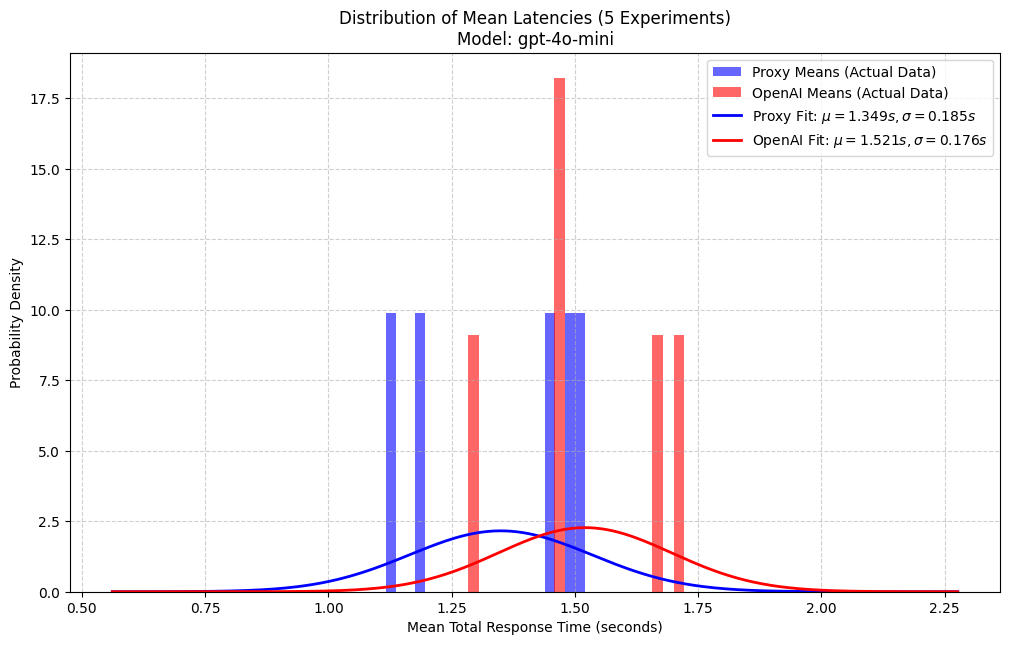

In [8]:
main_run()